Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [111]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob


In [112]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [113]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = Path("/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = Path("/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [114]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [115]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [116]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [117]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [118]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print(type(train_ds))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

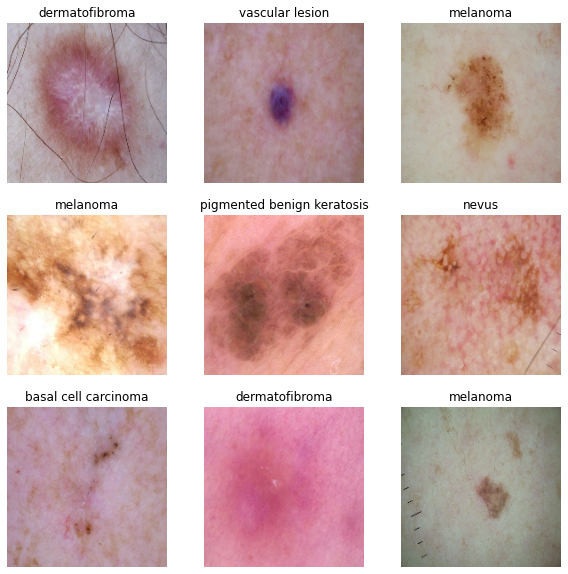

In [119]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")







The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [120]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [121]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [122]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [123]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [124]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 41s 82ms/step - loss: 1.9637 - accuracy: 0.2619 - val_loss: 1.7611 - val_accuracy: 0.3682
Epoch 2/20
169/169 [==============================] - 7s 41ms/step - loss: 1.4256 - accuracy: 0.4670 - val_loss: 1.2648 - val_accuracy: 0.5367
Epoch 3/20
169/169 [==============================] - 7s 41ms/step - loss: 1.1987 - accuracy: 0.5538 - val_loss: 1.1649 - val_accuracy: 0.5650
Epoch 4/20
169/169 [==============================] - 7s 41ms/step - loss: 1.0991 - accuracy: 0.6011 - val_loss: 1.0726 - val_accuracy: 0.6117
Epoch 5/20
169/169 [==============================] - 7s 41ms/step - loss: 0.8947 - accuracy: 0.6797 - val_loss: 0.9020 - val_accuracy: 0.6726
Epoch 6/20
169/169 [==============================] - 7s 41ms/step - loss: 0.7270 - accuracy: 0.7433 - val_loss: 0.8940 - val_accuracy: 0.6912
Epoch 7/20
169/169 [==============================] - 7s 41ms/step - loss: 0.5776 - accuracy: 0.7964 - val_loss: 0.8380 - val_accuracy: 0.717

### Visualizing training results

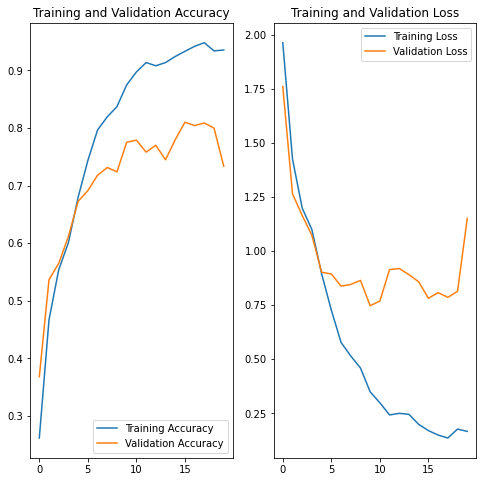

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
We see that the model has largely overfitted.
##### Accuracy
As the number of epochs are increasing the training accuracy increases but the validation accuracy continues to remain around 55%

##### Loss
On increasing the number of epochs the training loss has drastically reduced but the validation loss has spiked high

In [126]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

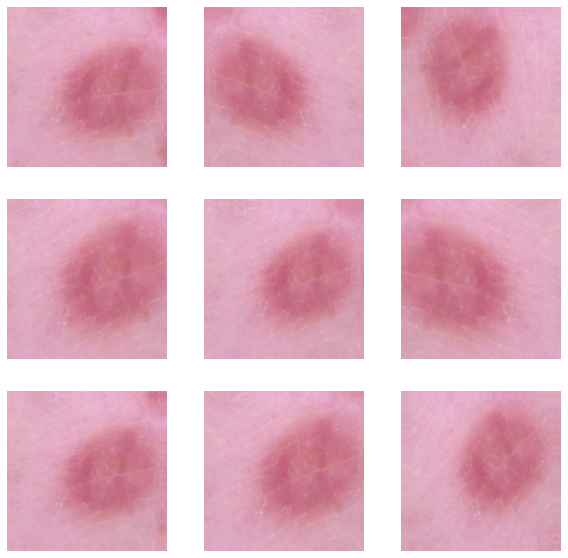

In [127]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [128]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [129]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [130]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 9s 47ms/step - loss: 2.0898 - accuracy: 0.2040 - val_loss: 1.7366 - val_accuracy: 0.3318
Epoch 2/20
169/169 [==============================] - 8s 46ms/step - loss: 1.5915 - accuracy: 0.4026 - val_loss: 1.6263 - val_accuracy: 0.3742
Epoch 3/20
169/169 [==============================] - 8s 46ms/step - loss: 1.4085 - accuracy: 0.4631 - val_loss: 1.2772 - val_accuracy: 0.5219
Epoch 4/20
169/169 [==============================] - 8s 46ms/step - loss: 1.2883 - accuracy: 0.5059 - val_loss: 1.1914 - val_accuracy: 0.5338
Epoch 5/20
169/169 [==============================] - 8s 46ms/step - loss: 1.2584 - accuracy: 0.5232 - val_loss: 1.1321 - val_accuracy: 0.5568
Epoch 6/20
169/169 [==============================] - 8s 46ms/step - loss: 1.1534 - accuracy: 0.5543 - val_loss: 1.1679 - val_accuracy: 0.5642
Epoch 7/20
169/169 [==============================] - 8s 46ms/step - loss: 1.0894 - accuracy: 0.5859 - val_loss: 1.0849 - val_accuracy: 0.5887

### Visualizing the results

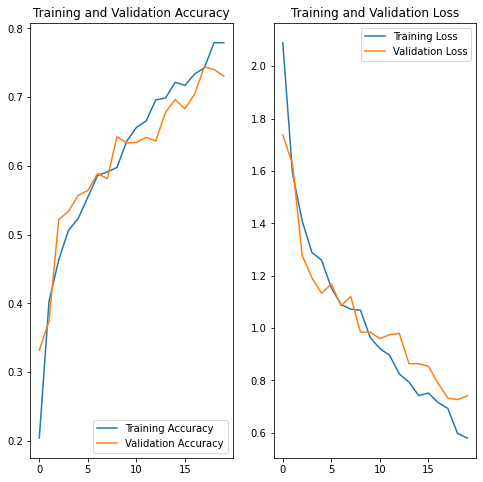

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The difference in training and validation accuracy has decreased significantly.
This is definitely better than the previous model and it doesnot overfit or underfit the data.
However the model accuracy could be better.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [132]:
## Your code goes here.

for name in class_names:
  #print( len(list(os.path.join('data_dir_train',name).glob('*/*.jpg'))))
  print( name ,len(list(glob(os.path.join(data_dir_train, name, '*.jpg')))))
  


actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [133]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [134]:
path_to_training_dataset=data_dir_train
print(data_dir_train)
import Augmentor
for i in class_names:
  #print(os.path.join(data_dir_train,i))
  p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)  
    

/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F54AA0DC090>: 100%|██████████| 500/500 [00:21<00:00, 23.13 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F54AA0DC690>: 100%|██████████| 500/500 [00:22<00:00, 22.61 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F54610DFE50>: 100%|██████████| 500/500 [00:22<00:00, 22.65 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F54051AF690>: 100%|██████████| 500/500 [01:58<00:00,  4.22 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F54AB096150>:   0%|          | 1/500 [00:00<01:34,  5.29 Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F5461008AD0>: 100%|██████████| 500/500 [01:30<00:00,  5.50 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F54AB0F7F90>:   0%|          | 1/500 [00:00<01:30,  5.50 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F54AA0DB790>: 100%|██████████| 500/500 [00:21<00:00, 23.44 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5404193C10>: 100%|██████████| 500/500 [00:48<00:00, 10.33 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F54F18205D0>:   0%|          | 1/500 [00:00<01:19,  6.24 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5461002A90>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F540502F0D0>: 100%|██████████| 500/500 [00:22<00:00, 21.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [135]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [136]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010533.jpg_4fd5282c-312b-4d88-8fc5-9dfdff795aaa.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010746.jpg_1425703b-4063-4aec-bebb-0ab35d7e3a5d.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_857c9d15-501f-4fd8-ae1b-44d154578bab.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000309.jpg_3bbb2930-c276-4866-a1d5-c2e795bd0c7c.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/

In [137]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [138]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [139]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [140]:
new_df['Label'].value_counts()

basal cell carcinoma          1000
vascular lesion               1000
squamous cell carcinoma       1000
actinic keratosis             1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
melanoma                      1000
dermatofibroma                1000
nevus                         1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [141]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [142]:

print(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=32)

/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [143]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [144]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [145]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [146]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 70s 243ms/step - loss: 1.8532 - accuracy: 0.2987 - val_loss: 1.4252 - val_accuracy: 0.4566
Epoch 2/30
281/281 [==============================] - 67s 234ms/step - loss: 1.3855 - accuracy: 0.4677 - val_loss: 1.2593 - val_accuracy: 0.5376
Epoch 3/30
281/281 [==============================] - 68s 237ms/step - loss: 1.2811 - accuracy: 0.5081 - val_loss: 1.2214 - val_accuracy: 0.5367
Epoch 4/30
281/281 [==============================] - 68s 238ms/step - loss: 1.1631 - accuracy: 0.5574 - val_loss: 1.2989 - val_accuracy: 0.5029
Epoch 5/30
281/281 [==============================] - 66s 232ms/step - loss: 1.0892 - accuracy: 0.5802 - val_loss: 0.9865 - val_accuracy: 0.6302
Epoch 6/30
281/281 [==============================] - 68s 238ms/step - loss: 1.0013 - accuracy: 0.6251 - val_loss: 0.9913 - val_accuracy: 0.6328
Epoch 7/30
281/281 [==============================] - 68s 239ms/step - loss: 0.9485 - accuracy: 0.6433 - val_loss: 0.9873 - val_ac

#### **Todo:**  Visualize the model results

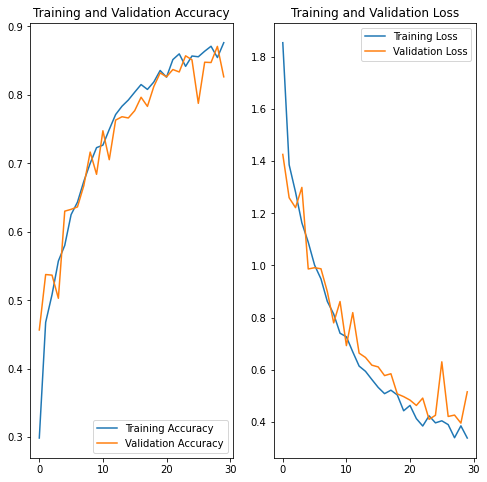

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The training accuracy is 87% and the validation accuracy is 82.64%.
Hence we can safely say that the model neither overfits nor underfits.
Class Rebalance has successfully helped to reduce overfitting.